In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", message="This pattern is interpreted as a regular expression")


### USA: 10Y Yield vs Inflation (funciona con "country|date|inflation_annual%")

In [2]:
# ---------- 1) Yields USA -> anual 10Y ----------
y = pd.read_csv('raw_data/us_treasury_yields_daily.csv')
# fecha
date_col = next((c for c in y.columns if c.lower() in {"date","fecha"}), None)
if date_col is None:
    raise ValueError("No encuentro columna de fecha en yields CSV.")
y[date_col] = pd.to_datetime(y[date_col], errors="coerce")
y = y.dropna(subset=[date_col])
# columna 10 años
def detect_10y_col(cols):
    for c in cols:
        cl = c.strip().lower()
        if cl in {"us10y","10y","10 yr","10-year","10 year","10_yr"}:
            return c
    for c in cols:
        cl = c.lower()
        if "10" in cl and ("yr" in cl or "year" in cl):
            return c
    if "US10Y" in cols: return "US10Y"
    if "10 Yr" in cols: return "10 Yr"
    raise ValueError(f"No encuentro columna 10Y en yields. Columnas: {list(cols)[:12]}")
col10 = detect_10y_col(y.columns)
# anual
y = y[[date_col, col10]].rename(columns={date_col:"date", col10:"yield_10y"})
y["Year"] = y["date"].dt.year.astype(int)
us_annual = y.groupby("Year", as_index=False)["yield_10y"].mean()
print("YIELDS USA — años:", us_annual["Year"].min(), "→", us_annual["Year"].max(), "| n:", len(us_annual))

YIELDS USA — años: 1962 → 2024 | n: 63


In [3]:
def extract_year_col(df, preferred_cols=("year","date","fecha","period","time","obs_date","observationdate")):
    """
    Devuelve una Serie 'Year' (int) extraída de la mejor columna disponible:
    - Si hay 'year' numérico, lo usa.
    - Si hay fechas, parsea a datetime y saca el año.
    - Si hay strings tipo '1960 [YR1960]' o 'YR1960', extrae los 4 dígitos por regex.
    """
    # 1) columna explícita de año
    for c in df.columns:
        if c.lower() in ("year","anio","año"):
            y = pd.to_numeric(df[c], errors="coerce")
            if y.notna().any():
                return y.astype("Int64")
    # 2) columnas “fecha”
    for cand in preferred_cols:
        for c in df.columns:
            if c.lower()==cand:
                # a) intentar datetime
                dt = pd.to_datetime(df[c], errors="coerce", dayfirst=False)
                if dt.notna().any():
                    return dt.dt.year.astype("Int64")
                # b) extraer patrón de 4 dígitos
                s = df[c].astype(str).str.extract(r'(\d{4})', expand=False)
                y = pd.to_numeric(s, errors="coerce")
                if y.notna().any():
                    return y.astype("Int64")
    # 3) si ninguna funciona, intentar extraer 4 dígitos de cualquier columna de texto
    for c in df.columns:
        if df[c].dtype==object:
            s = df[c].astype(str).str.extract(r'(\d{4})', expand=False)
            y = pd.to_numeric(s, errors="coerce")
            if y.notna().sum() >= len(df)*0.3:
                return y.astype("Int64")
    return pd.Series([pd.NA]*len(df), index=df.index, dtype="Int64")

In [4]:
def find_inflation_col(df):
    """
    Busca una columna de inflación (%). Prioriza nombres típicos.
    """
    prefs = ["inflation_annual%", "inflation_yoy", "inflation yoy", "inflation%", "inflation", "cpi_yoy", "cpi yoy"]
    # prioridad por nombre
    for p in prefs:
        for c in df.columns:
            if p.replace(" ","") in c.replace(" ","").lower():
                return c
    # si no, una 'value' genérica
    for c in df.columns:
        if "value" in c.lower() or "valor" in c.lower():
            return c
    # último recurso: columna numérica “prometedora”
    numc = [c for c in df.columns if pd.to_numeric(df[c], errors="coerce").notna().sum()>0]
    if numc:
        return numc[0]
    return None

In [5]:
def filter_country_usa(df):
    """
    Intenta filtrar USA por varias columnas posibles.
    """
    # a) 'Country Code' == USA
    for c in df.columns:
        if c.lower() in ("country code","country_code","iso3","isocode","code"):
            mask = df[c].astype(str).str.upper().eq("USA")
            if mask.any(): 
                return df.loc[mask].copy()
    # b) 'Country' / 'Country Name' contiene 'United States' o 'USA'
    for c in df.columns:
        if c.lower() in ("country","country name","pais"):
            mask = df[c].astype(str).str.contains(r"\b(united states|usa)\b", case=False, na=False)
            if mask.any():
                return df.loc[mask].copy()
    # si no hay país, asumimos que el archivo ya es solo USA (devolver tal cual)
    return df.copy()

In [6]:
# ========= DIAGNÓSTICO + EXTRACCIÓN ROBUSTA DE INFLACIÓN (USA) =========
m = pd.read_csv('raw_data/world_bank_development_indicators.csv')

# 1) filtrar USA
m_usa = filter_country_usa(m)

# 2) obtener Year robusto
m_usa["Year"] = extract_year_col(m_usa)

# 3) localizar columna de inflación
infl_col = find_inflation_col(m_usa)
if infl_col is None:
    raise RuntimeError("No encuentro columna de inflación en tu archivo macro. Revisa nombres de columnas.")

# 4) preparar inflación anual
infl = (
    m_usa[["Year", infl_col]]
      .rename(columns={infl_col:"inflation_yoy"})
      .assign(inflation_yoy=lambda d: pd.to_numeric(d["inflation_yoy"], errors="coerce"))
      .dropna(subset=["Year","inflation_yoy"])
)
infl["Year"] = infl["Year"].astype(int)

# Si es mensual (múltiples filas por año), promediamos
infl = infl.groupby("Year", as_index=False)["inflation_yoy"].mean()

print("Yields USA: ", us_annual["Year"].min(), "→", us_annual["Year"].max(), "| n:", len(us_annual))
print("Inflación USA:", infl["Year"].min() if len(infl) else None, "→", infl["Year"].max() if len(infl) else None, "| n:", len(infl))

# 5) forzar intersección y MERGE
min_year = max(us_annual["Year"].min(), infl["Year"].min())
max_year = min(us_annual["Year"].max(), infl["Year"].max())
infl_clip = infl[(infl["Year"]>=min_year) & (infl["Year"]<=max_year)]
ua_clip   = us_annual[(us_annual["Year"]>=min_year) & (us_annual["Year"]<=max_year)]

df = ua_clip.merge(infl_clip, on="Year", how="inner").sort_values("Year").reset_index(drop=True)
if df.empty:
    # diagnóstico extra
    print(">>> DEBUG — YEARS YIELDS:", sorted(us_annual["Year"].unique())[:10], "...", sorted(us_annual["Year"].unique())[-10:])
    print(">>> DEBUG — YEARS INFL :", sorted(infl["Year"].unique())[:10], "...", sorted(infl["Year"].unique())[-10:])
    raise RuntimeError("Sigue sin haber años comunes. Revisa que 'Year' se esté extrayendo bien del macro CSV.")

df["real_yield"] = df["yield_10y"] - df["inflation_yoy"]

print("Filas tras merge:", len(df))
print(df.head())

Yields USA:  1962 → 2024 | n: 63
Inflación USA: 1960 → 2022 | n: 63
Filas tras merge: 61
   Year  yield_10y  inflation_yoy  real_yield
0  1962   3.946064       1.198773    2.747291
1  1963   4.001566       1.239669    2.761897
2  1964   4.187360       1.278912    2.908448
3  1965   4.283695       1.585169    2.698526
4  1966   4.925040       3.015075    1.909965


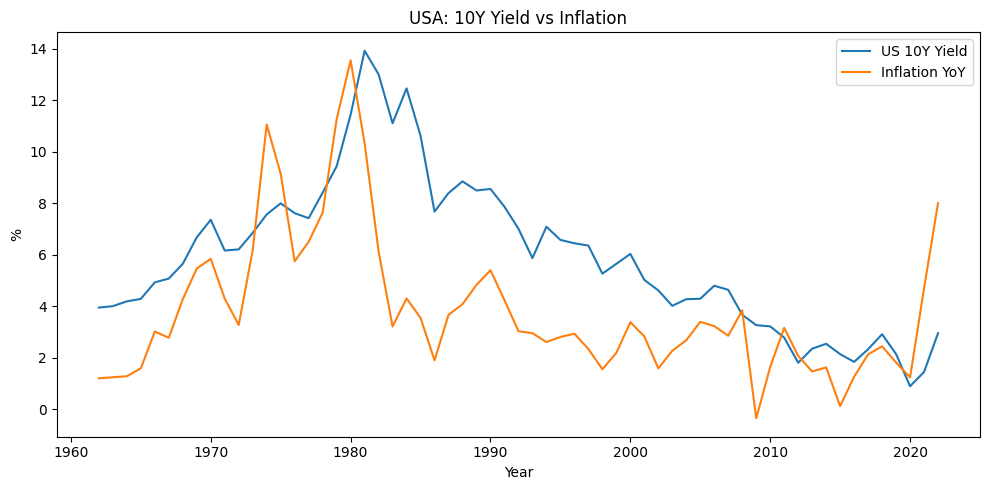

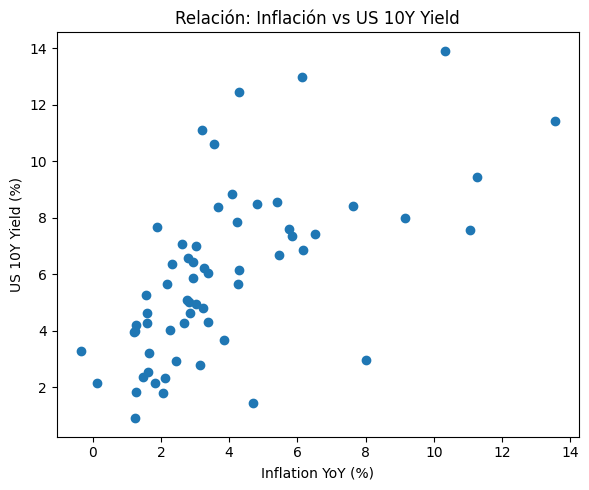

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df["Year"], df["yield_10y"], label="US 10Y Yield")
plt.plot(df["Year"], df["inflation_yoy"], label="Inflation YoY")
plt.title("USA: 10Y Yield vs Inflation")
plt.xlabel("Year"); plt.ylabel("%"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df["inflation_yoy"], df["yield_10y"])
plt.title("Relación: Inflación vs US 10Y Yield")
plt.xlabel("Inflation YoY (%)"); plt.ylabel("US 10Y Yield (%)")
plt.tight_layout(); plt.show()


#### 1. Serie temporal: USA 10Y Yield vs Inflación (líneas)

La línea azul (US 10Y Yield) muestra la rentabilidad de los bonos a 10 años.

La línea naranja (Inflation YoY) muestra la inflación anual.

Interpretación rápida:

En los años 70-80 se ve un pico muy alto de inflación y yield: es la época de la crisis del petróleo y la política monetaria dura de la Fed (Volcker subió tipos muy fuertes).

Desde los años 90 hasta 2020, ambos bajan gradualmente → entorno de baja inflación y yields decrecientes.

Después de 2020, la inflación se dispara otra vez (post-COVID, guerra, disrupciones en energía).

👉 Eso muestra que existe cierta relación: cuando la inflación sube fuerte, los yields suelen subir también, pero con rezagos o diferente magnitud.

#### 2. Diagrama de dispersión: Inflación vs Yield

Cada punto es un año (x = inflación, y = yield).

Se ve una nube ascendente: cuando la inflación es baja (0-4%), los yields tienden a estar en 2-6%.

Cuando la inflación es alta (6-12%), los yields también tienden a estar arriba (8-14%).

Interpretación rápida:

Hay una correlación positiva: inflación y yields tienden a moverse juntos.

Pero no es 1:1 → hay dispersión (porque los yields dependen también de política monetaria, expectativas, riesgo, etc.).

#### 3. Resumen antes de limpieza

Los datos ya muestran una relación clara: más inflación = más yield.

Pero hay ruido y valores extremos (ej: hiperinflación o datos atípicos que vimos en la tabla).

Por eso, la siguiente etapa de limpieza (quitar inflaciones absurdas, errores, etc.) servirá para tener relaciones más nítidas y modelos más confiables.

### Estadísticas básicas antes de limpiar


In [8]:
print("\n--- Correlación simple ---")
print(df[["yield_10y", "inflation_yoy"]].corr())

# Regresión lineal simple (Inflación -> Yield)
import statsmodels.api as sm

X = df["inflation_yoy"]
y = df["yield_10y"]

X = sm.add_constant(X)  # añadimos intercepto
model = sm.OLS(y, X).fit()

print("\n--- Regresión lineal simple ---")
print(model.summary())



--- Correlación simple ---
               yield_10y  inflation_yoy
yield_10y       1.000000       0.616816
inflation_yoy   0.616816       1.000000

--- Regresión lineal simple ---
                            OLS Regression Results                            
Dep. Variable:              yield_10y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     36.23
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           1.20e-07
Time:                        23:27:10   Log-Likelihood:                -137.94
No. Observations:                  61   AIC:                             279.9
Df Residuals:                      59   BIC:                             284.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    s

### 📊 Correlación simple

0.61 (positivo, moderado-fuerte) → Significa que cuando la inflación sube, los rendimientos del bono a 10 años en USA tienden a subir también.

No es una correlación perfecta (1.0), pero sí clara y estadísticamente significativa.

#### 📈 Regresión lineal simple

Modelo:

Yield 10Y

=
3.3783
+
0.6571
⋅
Inflaci
o
ˊ
n YoY
Yield 10Y=3.3783+0.6571⋅Inflaci
o
ˊ
n YoY

Constante (3.38): cuando la inflación es 0, el modelo predice un rendimiento del 3.38%.

Coeficiente (0.6571): por cada +1% en la inflación, el yield sube en promedio +0.65%.

p-valor (0.000): relación estadísticamente muy significativa.

R² = 0.38: la inflación explica el 38% de la variación en los yields.

Esto es bastante alto para datos macro, pero también nos dice que hay un 62% de variación que se explica por otros factores (ej. política monetaria, riesgo país, oferta/demanda global de bonos, etc.).

#### 📌 Conclusión preliminar

Existe una relación positiva clara entre inflación y yields en USA (1962–2024).

La inflación no lo explica todo, pero sí es un driver muy importante.

Esto tiene sentido económico: los inversores piden más rentabilidad en los bonos cuando esperan más inflación (para no perder poder adquisitivo).

✅ Resumen rápido (checkpoint):

cargamos y visualizamos las series de rendimiento del bono USA 10Y y inflación anual (1962–2024).

Encontramos una correlación positiva moderada (0.61) → cuando la inflación sube, los yields también tienden a subir.

La regresión lineal mostró que un +1% en inflación se asocia con un +0.65% en el yield 10Y, con R² = 0.38 → la inflación explica parte importante, pero no todo.

In [9]:
# Paso 1: Copiar y limpiar outliers
# ===============================

df_clean = df.copy()

# Quitamos inflaciones absurdas (ej. errores de dataset o hiperinflación)
df_clean = df_clean[df_clean["inflation_yoy"].between(-20, 50)]

print("Filas antes:", len(df), " | después:", len(df_clean))

# ===============================
# Paso 2: Recalcular real_yield
# ===============================

df_clean["real_yield"] = df_clean["yield_10y"] - df_clean["inflation_yoy"]

# ===============================
#  Exportar CSV limpio
# ===============================
df_clean.to_csv("clean_data/clean_code.csv", index=False)


Filas antes: 61  | después: 61


In [10]:
df_clean.head()

,Year,yield_10y,inflation_yoy,real_yield
0,1962,3.946064,1.198773,2.747291
1,1963,4.001566,1.239669,2.761897
2,1964,4.187360,1.278912,2.908448
3,1965,4.283695,1.585169,2.698526
4,1966,4.925040,3.015075,1.909965
